In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data=pd.read_csv('White Pages interviewData (1).csv')

In [3]:
data.shape

(325435, 27)

In [4]:
data.columns

Index(['key', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11',
       'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21',
       'v22', 'v23', 'v24', 'v25', 'd1_nob', 'd30_nob'],
      dtype='object')

### Data:
* Total of 325435 rows
* Total 25 features 
* Each row equals one specific deal
* Column d30_nob gives bookings on day in first 30 days of deal
* Column d1_nob gives bookings on first day of deal

### Checking if data has null values

In [5]:
data.isnull().any()

key        False
v2         False
v3         False
v4         False
v5         False
v6         False
v7         False
v8         False
v9         False
v10        False
v11        False
v12        False
v13        False
v14        False
v15        False
v16        False
v17        False
v18        False
v19        False
v20        False
v21        False
v22        False
v23        False
v24        False
v25        False
d1_nob     False
d30_nob    False
dtype: bool

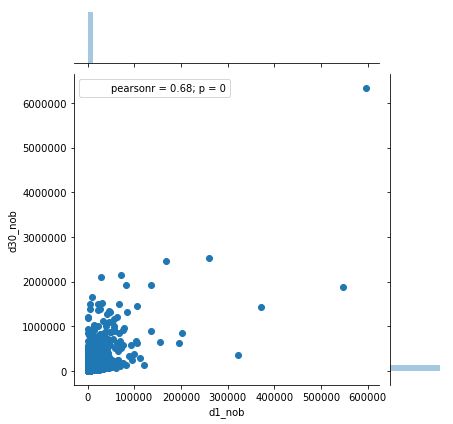

In [236]:
plt.figure(figsize=(15,12))
sns.jointplot(x=data['d1_nob'],y=data['d30_nob'],data=data)
plt.show()

### Preprocessing Data

In [70]:
analysisData=data.drop('key',axis=1)

In [71]:
analysisData.columns

Index(['v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12',
       'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21', 'v22',
       'v23', 'v24', 'v25', 'd1_nob', 'd30_nob'],
      dtype='object')

In [72]:
target=analysisData['d30_nob']

In [73]:
features=analysisData.iloc[:,0:-1]

### Splitting data into training and test dataset

In [75]:
features,features_test,target,target_test=train_test_split(features,target,test_size=.10,random_state=100)

In [76]:
features.shape

(292891, 25)

In [77]:
target.shape

(292891,)

### Preprocessing categorical features:

In [78]:
catFeatures1=features.iloc[:,0:8]
catFeatures1.columns

Index(['v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9'], dtype='object')

In [79]:
catFeatures2=features.iloc[:,19:24]
catFeatures2.columns

Index(['v21', 'v22', 'v23', 'v24', 'v25'], dtype='object')

In [80]:
catFeatures=pd.concat([catFeatures1,catFeatures2],axis=1)

In [82]:
catFeatures.describe()

,v2,v3,v4,v5,v6,v7,v8,v9,v21,v22,v23,v24,v25
count,292891,292891,292891,292891,292891,292891,292891,292891,292891,292891,292891,292891,292891
unique,10,5,173,2,2,13,141,495,11,111,3736,7,3
top,7df127bf,5ff698d7,78dc5fd9,df0206c4,df0206c4,bea3971a,fab7b5ef,40f86a0,5ff698d7,180905cb,86b6cf1f,592bc6e2,9af05131
freq,97862,162332,153443,173405,173405,179358,124690,120077,162414,99012,119492,136501,152636


# Encoding Categorical Featues:
 
* To convert the categorical data to numbers, we can use label encoding, one hot encoding or make dummy variables representing each value as a separate feature.
* Since we cannot assume that there is an ordinal relationship between categories, so label encoding is not an option.
* since the total number of unique categories in feature "v23" is 3736, one hot encoding would explode the data.
* Thus we have an option of making dummy variables for each category. But the question arises, are all categories equally important? 

### Finding most important categories of each feature`

* Let's plot 'd30_nob' for each category of features.

In [181]:
def plotTargetVsCatFeature(catFeatures,target):
    
    tempData=pd.concat([catFeatures,target],axis=1)
    for i in catFeatures:
        n_categories=(catFeatures[str(i)].nunique())
        if n_categories>15:
            
            temp=(tempData.groupby(str(i), as_index=False)['d30_nob'].sum())
            temp.sort_values('d30_nob',inplace=True,ascending=False) 
            sns.stripplot(x=str(i),y='d30_nob',data=temp)    
            plt.show()

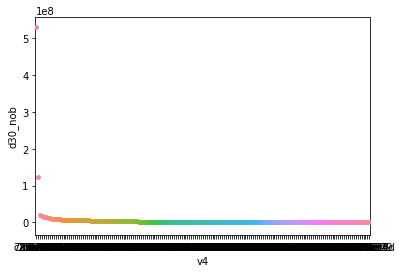

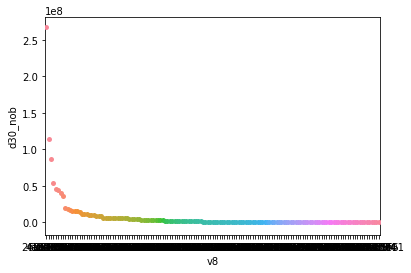

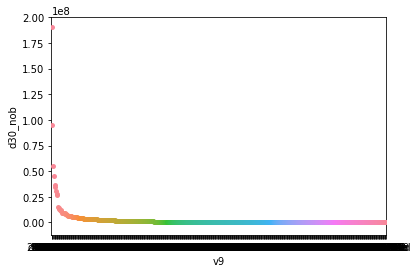

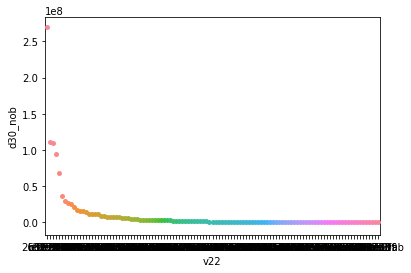

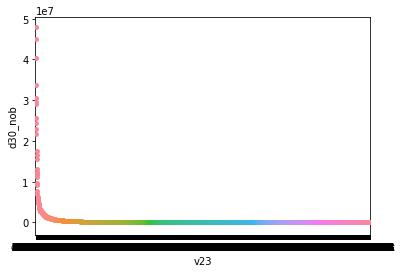

In [182]:
plotTargetVsCatFeature(catFeatures,target)

### Plotting Cumulative Sums of 'd30_nob' for each category in features with high number of categories

In [183]:
def cumSumCategories(catFeatures,target):
    tempData=pd.concat([catFeatures,target],axis=1)
    for i in catFeatures:
        n_categories=(catFeatures[str(i)].nunique())
        if n_categories>15:
            temp1=(tempData.groupby(str(i), as_index=False)['d30_nob'].sum())
            #cutOff=temp1['d30_nob'].cumsum()
            temp1.sort_values('d30_nob',inplace=True,ascending=False) 
            temp1['cumSum']=temp1['d30_nob'].cumsum()
            sns.stripplot(x=str(i),y='cumSum',data=temp1)    
            plt.show()    

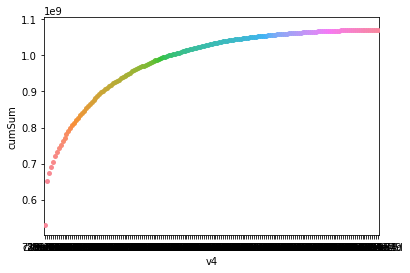

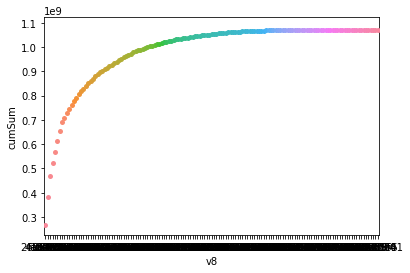

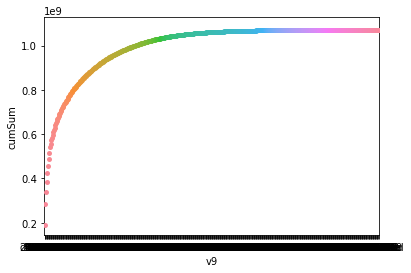

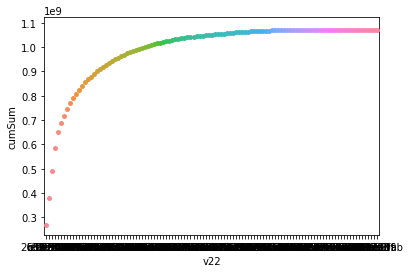

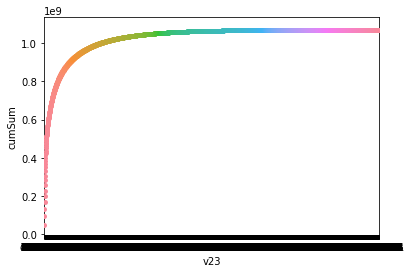

In [184]:
cumSumCategories(catFeatures,target)

* These are the plots of cumulative sums of 'd30_nob' for each feature whose number of categories are greater than 15.
* I see that 'v23' has more categories that aren't much useful and these categories are large in number. 
* Thus I find the value of 'd30_nob' where  the curve starts to flatten out (signifying categories that aren't adding much to cumsum now).
* Then I simple group all the next categories (which aren't adding much to cumSum and to our information) into one category.

In [83]:
def groupCategories(featurestemp,targettemp):
    tempData=pd.concat([featurestemp,targettemp],axis=1)
    
    temp1=(tempData.groupby('v23', as_index=False)['d30_nob'].sum())
    temp1.sort_values('d30_nob',inplace=True,ascending=False) 
    temp1['cumsum']=temp1['d30_nob'].cumsum()
    temp1['cum_perc']=100*temp1['cumsum']/temp1['d30_nob'].sum()

    lst=(temp1[temp1['cum_perc']>95])['v23']
    for i in lst:
       
      tempData.loc[tempData['v23']==str(i),'v23']='cat_lte_95'
    
    return lst,tempData.iloc[:,0:-1]

In [84]:
lst,catF=groupCategories(catFeatures,target)

In [85]:
cFeatures=catF.copy()

In [89]:
 target.describe()

count    2.928910e+05
mean     3.657873e+03
std      2.804630e+04
min      0.000000e+00
25%      3.998000e+01
50%      1.800000e+02
75%      1.000290e+03
max      6.328260e+06
Name: d30_nob, dtype: float64

* The mean is greater than the median, signifying positively skewed data.

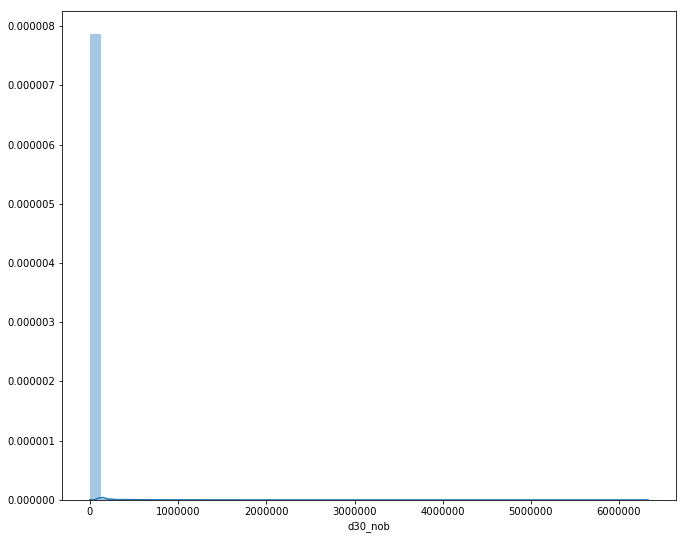

In [190]:
plt.figure(figsize=(11,9))
ax=sns.distplot(target)
plt.show()

### Categorical -> Numerical

* To convert categorical data to numerical, we can replace each category with its mean of target variable.
* We can also use pd.get_dummies to form dummy features representing each category.
* We can one hot encode too. 
* I am going to use the first method i.e replace each category in each feature with the mean of d30_nob for that category.

In [ ]:
def replace_Category(features,target):
    tempData=pd.concat([features,target],axis=1)
    mean={}
    for i in features:
        
        lst=tempData[str(i)].unique()
        temp=(tempData.groupby(str(i), as_index=False)['d30_nob'].mean())
        mean[i]=temp
        if i=='v2':
        for j in lst:   
            val=(temp.loc[temp[str(i)]==str(j),'d30_nob'])               
                            
            tempData.loc[tempData[str(i)]==str(j),str(i)]=val.iloc[0]
               
    return mean,tempData.iloc[:,0:-1]

In [ ]:
mean,newFeatures=replace_Category(cFeatures,target)

In [96]:
featureSet=pd.concat([newFeatures,features.iloc[:,8:19],features['d1_nob']],axis=1)

### Correlation among continuous features

In [97]:
corr=features.corr()

In [98]:
corr

,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,d1_nob
v10,1.000000,0.001511,0.082858,0.147889,0.166066,-0.073656,-0.025926,0.005064,0.003661,0.051811,0.073806,0.041347
v11,0.001511,1.000000,0.031350,0.033426,0.032789,-0.012538,-0.004350,0.000142,0.014681,0.018406,0.019436,0.031461
v12,0.082858,0.031350,1.000000,0.941834,0.841574,0.100049,0.168941,0.037387,0.736503,0.733226,0.656736,0.035657
v13,0.147889,0.033426,0.941834,1.000000,0.965738,0.086261,0.210533,0.050597,0.690311,0.775587,0.761341,0.040358
v14,0.166066,0.032789,0.841574,0.965738,1.000000,0.072958,0.227931,0.057807,0.614610,0.757548,0.808539,0.041073
v15,-0.073656,-0.012538,0.100049,0.086261,0.072958,1.000000,0.896802,0.113887,0.151310,0.146849,0.132674,-0.008846
v16,-0.025926,-0.004350,0.168941,0.210533,0.227931,0.896802,1.000000,0.428896,0.197413,0.252967,0.274402,-0.003323
v17,0.005064,0.000142,0.037387,0.050597,0.057807,0.113887,0.428896,1.000000,0.035847,0.051237,0.060289,-0.000050
v18,0.003661,0.014681,0.736503,0.690311,0.614610,0.151310,0.197413,0.035847,1.000000,0.939670,0.806900,0.011554
v19,0.051811,0.018406,0.733226,0.775587,0.757548,0.146849,0.252967,0.051237,0.939670,1.000000,0.949735,0.016654


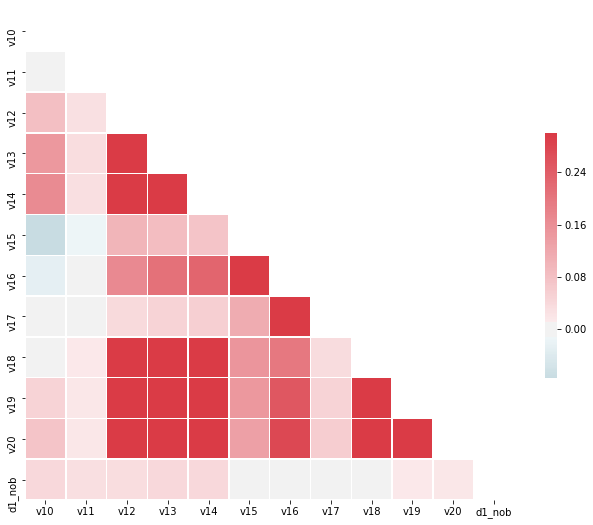

In [99]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

* Feature 'v10' has the highest correlation with 'd30_nob'.
* Features v12,v13 and v14 have almost same correlation with d30_nob
* Features v15,v16,v17 and v18have nearly same correlation with d30_nob


In [100]:
featureSet.shape

(292891, 25)

## Model Training

In [231]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

### Transform categorical test data with values learnt from training set

In [103]:
def transformTestData(features,mean):
    tempData=features.copy()
    for col in mean.keys():
        meanDF=mean[col]
        categories=meanDF[col]
        unique_Test_Cats=tempData[col].unique()
        c=[]
        for i in range(len(categories)):
            c.append(categories.iloc[i])
        count=0
        for cats in unique_Test_Cats:
            if str(cats) in c:
                val=(meanDF.loc[meanDF[col]==cats,'d30_nob']).iloc[0]
                tempData.loc[tempData[col]==str(cats),str(col)]=val
            else:
                count+=1
                if col=='v23' and (cats) in lst:
                    tempData.loc[tempData[col]==str(cats),str(col)]=mean['v23'].loc[mean['v23']['v23']=='cat_lte_95']['d30_nob'].iloc[0]
                else:
                    tempData.loc[tempData[col]==str(cats),str(col)]=0
        print(count,"0s for",col)
    return(tempData.iloc[:,:])
    

In [104]:
testFeaturesTemp=transformTestData(features_test,mean)

0 0s for v25
1 0s for v9
0 0s for v5
0 0s for v2
1456 0s for v23
0 0s for v6
0 0s for v21
0 0s for v8
0 0s for v22
0 0s for v7
0 0s for v24
0 0s for v4
0 0s for v3


In [164]:
tempFtrain=featureSet.copy() #Copy of Training Features
tempTtrain=target.copy() #Copy of Training Target Values
tempFtest=testFeaturesTemp.copy() #Copy of Testing Features
tempTtest=target_test.copy() #Copy of Testing Targets

### Metrics:
* Mean Absolute Error gives the average magnitude of error in the set of predictions, without considering the direction. 
* Root mean square Error gives square root of average of squared differences in predictions vs target.
* Since MAE is better in scenarios where we are concerned about all the differences in predictions and target, however small or large (such as this case where we have equal priority for all differences and being off by 10 is equall bad as being off by 20), I am going to use MAE.

In [234]:
def crossValidation(model,features_train,target_train,features_test,target_test):
    print("cross Val Score: ",cross_val_score(clf,features_train,target_train,scoring=make_scorer(mean_absolute_error)))
    model=model.fit(features_train,target_train)
    y_pred=model.predict(features_test)
    print(mean_absolute_error(target_test,y_pred))

In [109]:
lr=LinearRegression(normalize=True)
crossValidation(lr,tempFtrain,tempTtrain,tempFtest,tempTtest)

cross Val Score:  [ 3200.89454956  3422.80893496  3276.87114518]
344956.516081


In [110]:
dt=DecisionTreeRegressor()
crossValidation(dt,tempFtrain,tempTtrain,tempFtest,tempTtest)

cross Val Score:  [ 3076.21447909  3040.63692623  2946.40348968]
18851.1664398


In [111]:
rf=RandomForestRegressor()
crossValidation(rf,tempFtrain,tempTtrain,tempFtest,tempTtest)

cross Val Score:  [ 2414.74375737  2469.2065235   2366.21680269]
13454.5385707


In [112]:
ad=AdaBoostRegressor()
crossValidation(ad,tempFtrain,tempTtrain,tempFtest,tempTtest)

cross Val Score:  [ 13781.48279783  80064.8075542    9777.99631302]
11053.5970616


In [113]:
knn=KNeighborsRegressor()
crossValidation(knn,tempFtrain,tempTtrain,tempFtest,tempTtest)

cross Val Score:  [ 2527.96363614  2557.12016644  2449.56757269]
3502.37466366


In [197]:
ridge=Ridge(alpha=1.5,normalize=True,solver='auto')
crossValidation(ridge,tempFtrain,tempTtrain,tempFtest,tempTtest)

cross Val Score:  [ 3423.19279286  3470.18191973  3260.5356523 ]
12826.3855651


* Regularizing the model helps a little with the overfitting problem of Linear Regression.

### Grid search for finding optimal hyperparameters

In [509]:
from sklearn.model_selection import GridSearchCV

In [204]:
def gridSearch(model,params,features,target):   
    gs=GridSearchCV(model,params,cv=5,scoring=make_scorer(mean_absolute_error))
    gs.fit(features,target)
    print("Best parameters set found: ")
    print()
    print(gs.best_params_)
    print()
    print("MAE: ",mean_absolute_error(target,gs.predict(features)))

In [ ]:
params={'n_estimators':[10,20],'max_depth':[10,20],'min_samples_split':[10,20]}
rf=RandomForestRegressor()
gridSearch(rf,params,featureSet,target)

In [244]:
def residual(model1,model2,features_train,target_train,features_test,targets_test,scorer):
    clf1=model1
    clf1=clf1.fit(features_train,target_train)
    y_pred1=clf1.predict(features_train)
    err=scorer(target_train,y_pred1)
    residual=(np.subtract(target_train,y_pred1))
    clf2=model2
    clf2=clf2.fit(features_train,residual)
    y_pred2=clf2.predict(features_train)
    y_pred=(np.add(y_pred1,y_pred2))
    print(scorer(target_train,y_pred))
    #l2_features_train=pd.concat([l2_features_train,])
    y_pred_Test_clf1=clf1.predict(features_test)
    y_pred_Test_clf2=(clf2.predict(features_test))
    y_pred_test=np.add(y_pred_Test_clf1,y_pred_Test_clf2)
    print("MAE: ",scorer(targets_test,y_pred_test))    
    return y_pred_test

In [243]:
pred=residual(LinearRegression(normalize=True),DecisionTreeRegressor(),tempFtrain,tempTtrain,tempFtest,tempTtest,mean_absolute_error)

KeyboardInterrupt: 

In [247]:
def category_wise_error(pred,test_features,test_targets):
    tempData=pd.concat([test_features,test_targets],axis=1)
    tempData['Error']=np.subtract(pred,test_targets)
    for i in test_features.columns:
        categories=tempData[str(i)].unique()
        temp1=(tempData.groupby(str(i), as_index=False)['Error'].mean())
        temp1.sort_values('Error',inplace=True,ascending=False) 
        sns.stripplot(x=str(i),y='Error',data=temp1)    
        plt.show()

In [232]:
residual(Lasso(normalize=True),RandomForestRegressor(),tempFtrain,tempTtrain,tempFtest,tempTtest,mean_absolute_error)

941.148928264
MAE:  17316.6392252


In [245]:
pred=residual(Ridge(alpha=1.5,normalize=True,copy_X=True),RandomForestRegressor(),tempFtrain,tempTtrain,tempFtest,tempTtest,mean_absolute_error)

945.9602647
MAE:  14378.6028964


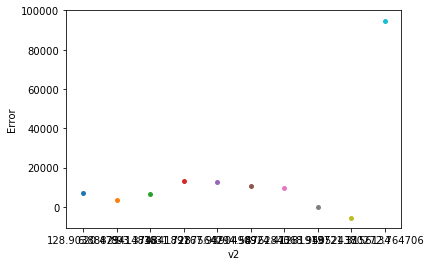

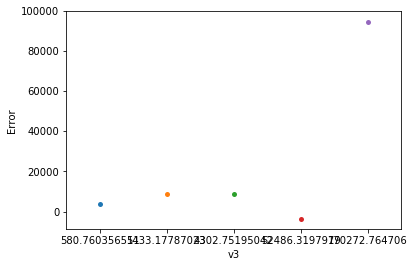

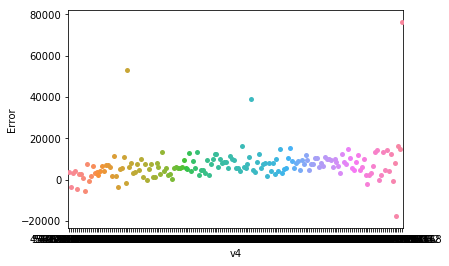

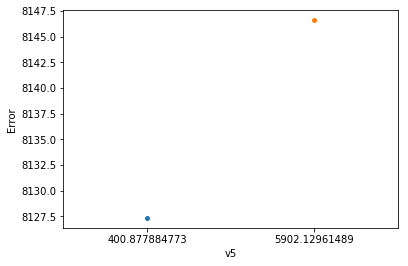

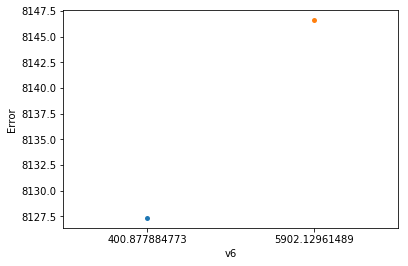

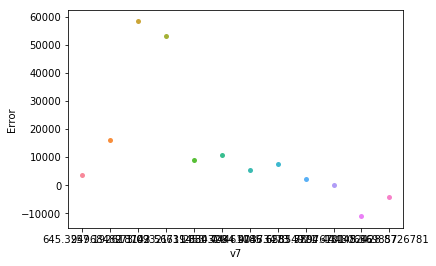

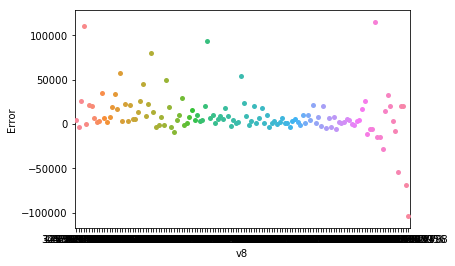

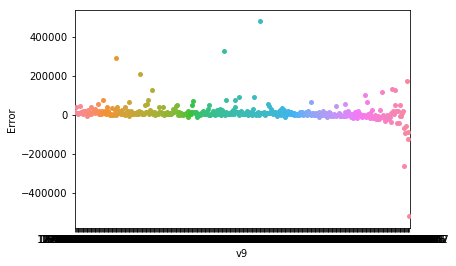

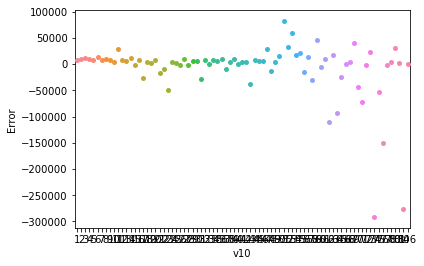

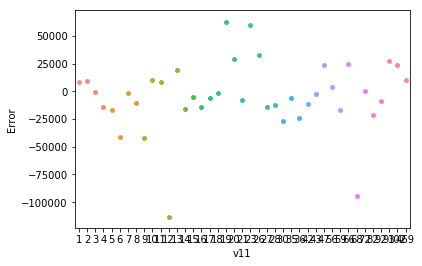

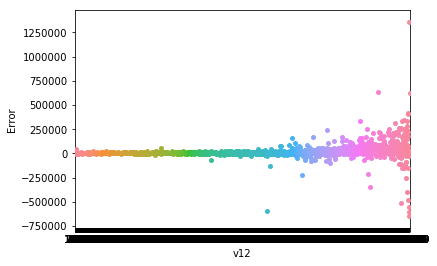

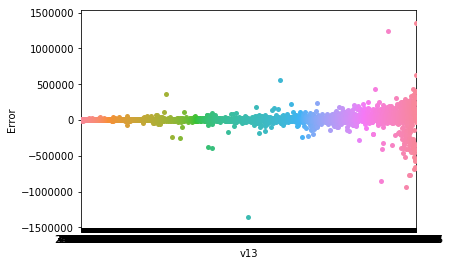

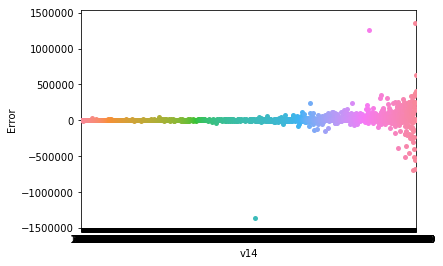

KeyboardInterrupt: 

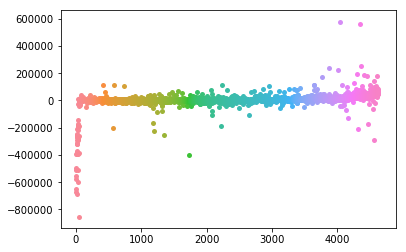

In [248]:
category_wise_error(pred,tempFtest,tempTtest)

* Sorry couldn't wait for all the visualization to finish till last feature. My time had finished.

* Increasing regularization strength to improve the conditioning of the problem.

In [235]:
residual(Ridge(normalize=True,copy_X=True),KNeighborsRegressor(),tempFtrain,tempTtrain,tempFtest,tempTtest,mean_absolute_error)

1946.69646374
MAE:  15775.7031587


### Model Analysis:
* Nearly 1450 datapoints in Target Feature Set have been assigned value 0 for some categories found in test. 
* These categories are the ones found in test Set but which weren't come across in training set.
* As seen from the last plots, Error is 0 for majority of the categories of Target Features set.
* While some categories have very high mean error, like in v12, I still have huge outliers that add to the error in predictions.